# Physics informed neural networks


## Resources 
- [Physics Informed Neural Networks](https://maziarraissi.github.io/PINNs/)
- [BFGS vs Adam](https://stats.stackexchange.com/questions/315626/the-reason-of-superiority-of-limited-memory-bfgs-over-adam-solver)
- [BFGS](https://machinelearningmastery.com/bfgs-optimization-in-python/)
- [Another TF2 PINN implementation](https://github.com/pierremtb/PINNs-TF2.0)
- [MLTP 2020 Presentation](https://mltp2020.com/Presentations/Karniadakis_NSF_MLTP2020.pdf)
- [CIS522: Deep learning](https://www.seas.upenn.edu/~cis522/slides/CIS522_Lecture11T.pdf)



# Imports and functions

In [1]:
# !git clone https://github.com/maziarraissi/PINNs.git

In [2]:
# !pip install scipy==1.7
# !pip install pyDOE

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import scipy
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from pyDOE import lhs


In [4]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata

def plot_results(U_pred, X_u_train, truth, x, t):
    # copied this figure directly from the paper
    plt.figure(figsize=(15,10))   
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
                    extent=[t.min(), t.max(), x.min(), x.max()], 
                    origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(h, cax=cax)

    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'upper right')
    ax.set_title('$u(t,x)$', fontsize = 10)

    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,truth[25,:], 'b-', linewidth = 2, label = 'truth')       
    ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')    
    ax.set_title('$t = 0.25$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])

    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,truth[50,:], 'b-', linewidth = 2, label = 'truth')       
    ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 0.50$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,truth[75,:], 'b-', linewidth = 2, label = 'truth')       
    ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])    
    ax.set_title('$t = 0.75$', fontsize = 10)
    plt.show();

# Data

In [5]:
# data = loadmat('/content/PINNs/appendix/Data/burgers_shock.mat')
data = loadmat('./burgers_shock.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'x', 't', 'usol'])

In [6]:
data['x'].shape, data['t'].shape, data['usol'].shape

((256, 1), (100, 1), (256, 100))

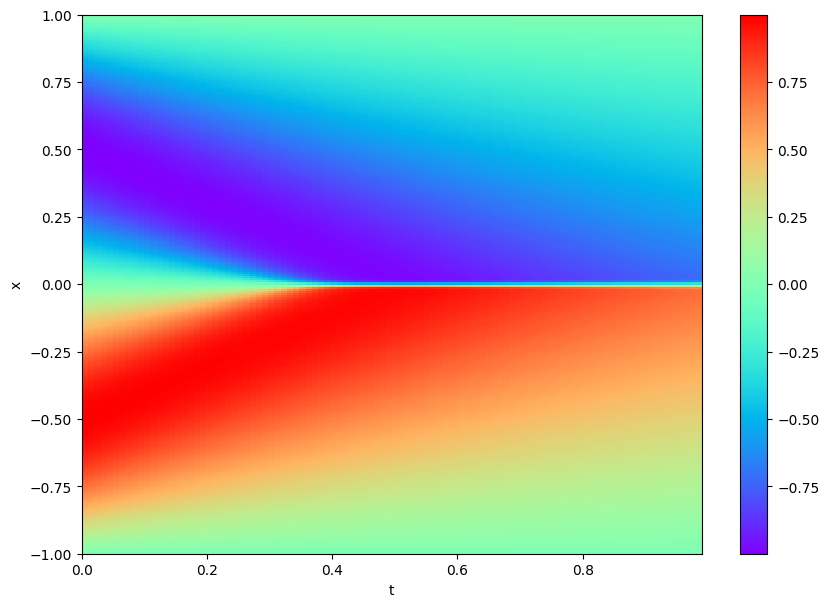

In [7]:
plt.figure(figsize=(10,7))
fig = plt.imshow(data['usol'], interpolation='nearest', cmap='rainbow', 
            extent=[data['t'].min(), data['t'].max(), data['x'].min(), data['x'].max()], 
            origin='lower', aspect='auto')
plt.xlabel('t')
plt.ylabel('x')
plt.colorbar()
plt.show();


This is the basic function the NN is trying to learn, but doesn't include any information about additional derivative behavior. This is just surface features.

Build all of the data including the boundary and interior points for $u$ and $f$

In [8]:
np.random.seed(42)

# data
N_u = 50
N_f = 10000

# extract data from matlab file
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]

# true values of U
truth = np.real(data['usol']).T

# mesh grid of inputs
X, T = np.meshgrid(x,t)

# all data (reduce for RAM)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = truth.flatten()[:,None]
# idx = np.random.choice(X_star.shape[0], 12800, replace=False)
# X_star = X_star[idx,:]
# u_star = u_star[idx,:]

# Domain bounds
lb = X_star.min(0)
ub = X_star.max(0)  

# build inputs and outputs for U(t,x)
# paper and code repo swap order ot t and x in U(t,x)

#(x, 0) data with x, t=0. Eq 3 u(0,x) = -sin(pi*x)
xt0 = np.hstack((X[0:1,:].T, T[0:1,:].T))
u_xt0 = truth[0:1,:].T # solutions to u(0,x)

#(-1, t) data with x=-1, t. Eq 3 u(t,-1) = 0
xminus1t = np.hstack((X[:,0:1], T[:,0:1]))
u_xminus1t = truth[:,0:1] # solutions to u(t,-1)

#(1, t) data with x=1, t. Eq 3 u(t,1) = 0
x1t = np.hstack((X[:,-1:], T[:,-1:]))
u_x1t = truth[:,-1:]

X_u_train = np.vstack([xt0, xminus1t, x1t])
u_train = np.vstack([u_xt0, u_xminus1t, u_x1t])


idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

# build input for f(t,x), f=0

# X_f_train is combination of boundary data above and hypercube sample scaled
# when passed into f it should equal zero
X_f_train = lb + (ub-lb)*lhs(2, N_f)

X_u_train.shape, u_train.shape, X_f_train.shape, X_star.shape, u_star.shape, X.shape

((50, 2), (50, 1), (10000, 2), (25600, 2), (25600, 1), (100, 256))

In [9]:
X_f_train

array([[ 0.0412089 ,  0.87271186],
       [ 0.44606178,  0.43545991],
       [ 0.6856612 ,  0.8142714 ],
       ...,
       [-0.20610397,  0.48534616],
       [ 0.11326385,  0.79674134],
       [ 0.03567754,  0.54043731]])

# Naive version
Just model U without additional partial derivative information

## Model

In [10]:
initializer = tf.keras.initializers.GlorotNormal()

inputs = layers.Input(shape=(2,), dtype=tf.float64)
z = layers.Lambda(lambda X: 2.0*(X - lb)/(ub - lb) - 1.0)(inputs)
z = layers.Dense(20, activation="tanh", kernel_initializer=initializer)(z)
z = layers.Dense(20, activation="tanh", kernel_initializer=initializer)(z)
z = layers.Dense(20, activation="tanh", kernel_initializer=initializer)(z)
z = layers.Dense(20, activation="tanh", kernel_initializer=initializer)(z)
z = layers.Dense(20, activation="tanh", kernel_initializer=initializer)(z)
z = layers.Dense(20, activation="tanh", kernel_initializer=initializer)(z)
outputs = layers.Dense(1, kernel_initializer=initializer)(z)

U_model_naive = tf.keras.Model(inputs=inputs, outputs=outputs)

U_model_naive.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
lambda (Lambda)              (None, 2)                 0         
_________________________________________________________________
dense (Dense)                (None, 20)                60        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_4 (Dense)              (None, 20)                420   

In [11]:
BATCH_SIZE = 32
EPOCHS = 1000

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01,
                                     beta_1=0.99,
                                     epsilon=1e-1)

f_batch_size = np.floor(X_f_train.shape[0] / (X_u_train.shape[0] / BATCH_SIZE))
f_batch_size

6400.0

## training

In [12]:
U_dataset = tf.data.Dataset.from_tensor_slices((X_u_train, u_train))
U_dataset = U_dataset.shuffle(buffer_size=100).batch(BATCH_SIZE)

# @tf.function
def train_step(X_u, u_true):
    with tf.GradientTape() as tape:

        u_pred = tf.cast(U_model_naive(X_u), tf.float64)

        loss = tf.losses.MeanSquaredError()(u_true, u_pred)
    grads = tape.gradient(loss, U_model_naive.trainable_weights)
    optimizer.apply_gradients(zip(grads, U_model_naive.trainable_weights))
    return loss

loss_hist = []
for epoch in range(EPOCHS):
    ep_loss = []
    for step, (X_u_batch_train, u_batch_train) in enumerate(U_dataset):

        loss_i = train_step(X_u_batch_train, u_batch_train)
        ep_loss.append(loss_i)
    
    loss_hist.append(tf.reduce_mean(ep_loss))

    U_dataset = tf.data.Dataset.from_tensor_slices((X_u_train, u_train))
    U_dataset = U_dataset.shuffle(buffer_size=100).batch(BATCH_SIZE)

    if epoch % 10 == 0:
        print(f"Epoch {epoch} Loss: {tf.reduce_mean(ep_loss)}")

Epoch 0 Loss: 0.3341778293251991
Epoch 10 Loss: 0.2841505706310272
Epoch 20 Loss: 0.27277398109436035
Epoch 30 Loss: 0.24993514269590378
Epoch 40 Loss: 0.2680903598666191
Epoch 50 Loss: 0.24298344552516937
Epoch 60 Loss: 0.22991688549518585
Epoch 70 Loss: 0.21154410392045975
Epoch 80 Loss: 0.19241570681333542
Epoch 90 Loss: 0.18682265281677246
Epoch 100 Loss: 0.16564837098121643
Epoch 110 Loss: 0.13502836972475052
Epoch 120 Loss: 0.09716382250189781
Epoch 130 Loss: 0.06523966230452061
Epoch 140 Loss: 0.032366774044930935
Epoch 150 Loss: 0.022899927105754614
Epoch 160 Loss: 0.031280433759093285
Epoch 170 Loss: 0.04207831062376499
Epoch 180 Loss: 0.04263390228152275
Epoch 190 Loss: 0.03374782297760248
Epoch 200 Loss: 0.026003392413258553
Epoch 210 Loss: 0.021781387738883495
Epoch 220 Loss: 0.022258764132857323
Epoch 230 Loss: 0.022131657227873802
Epoch 240 Loss: 0.020470835268497467
Epoch 250 Loss: 0.02140506263822317
Epoch 260 Loss: 0.016566480975598097
Epoch 270 Loss: 0.014024814125150

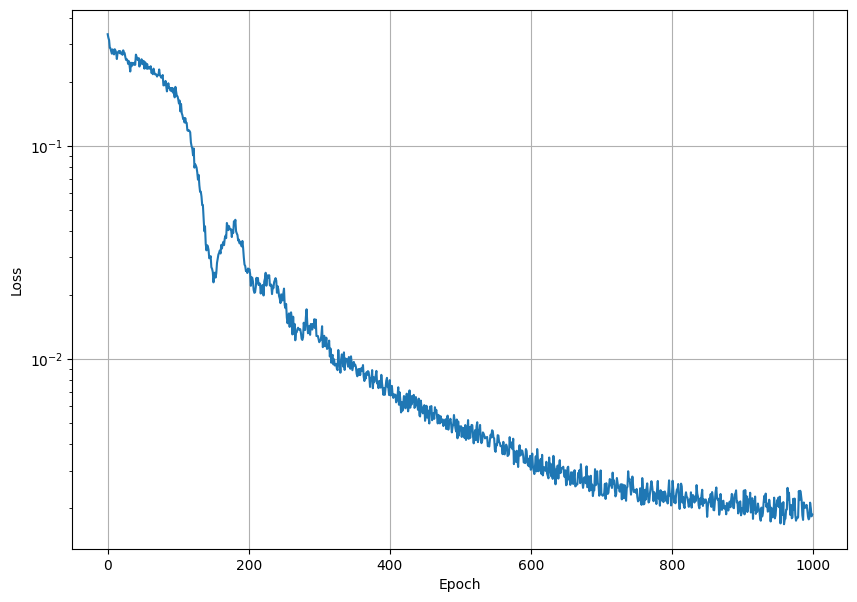

In [13]:
plt.figure(figsize=(10,7))
plt.semilogy(loss_hist)
plt.grid()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [15]:
u_pred_naive = U_model_naive.predict(X_star)
        
error_u_naive = np.linalg.norm(u_star-u_pred_naive,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u_naive))

Error u: 4.071028e-01


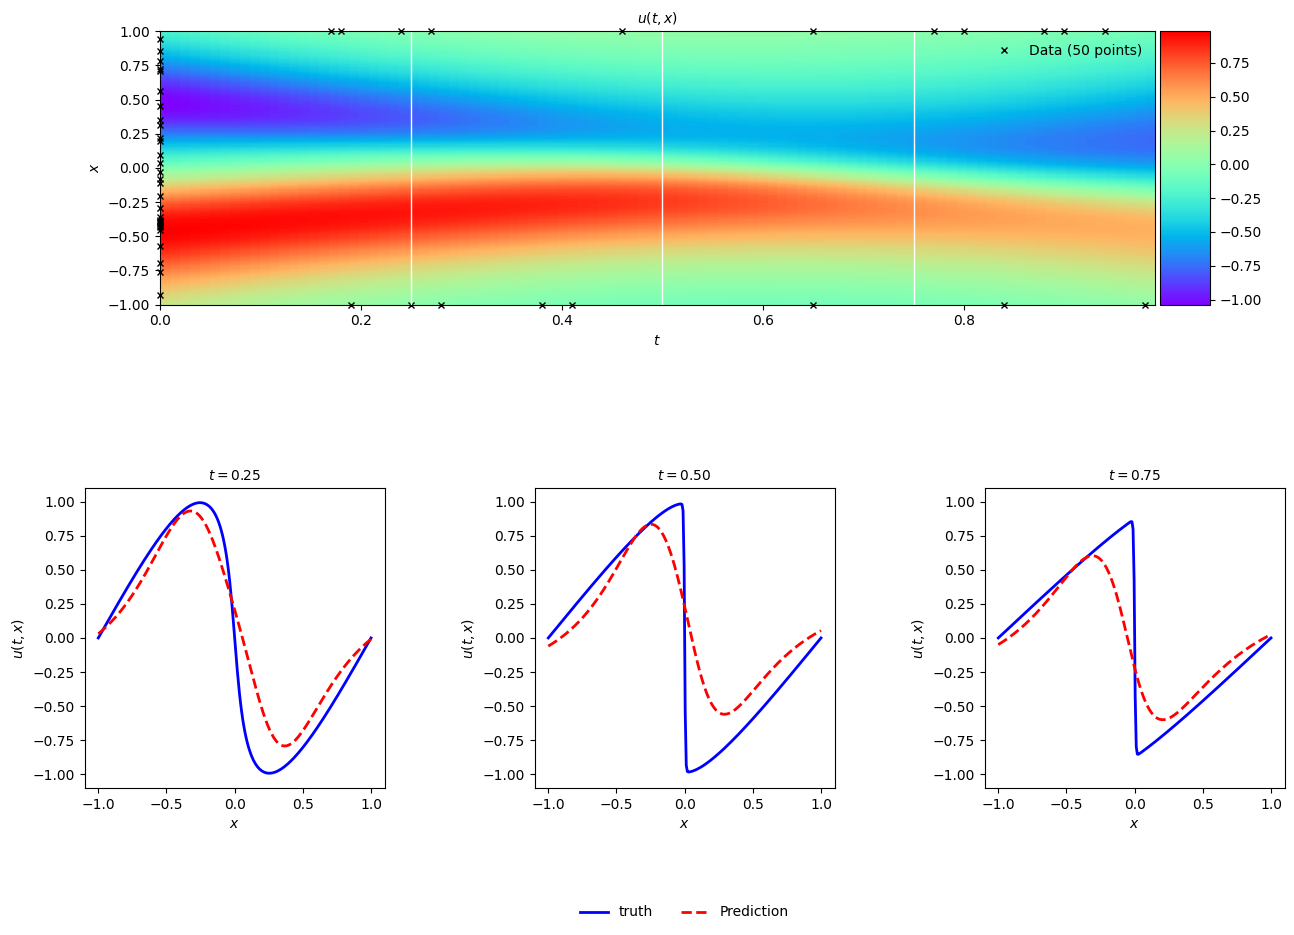

In [16]:
U_pred_naive = griddata(X_star, u_pred_naive.flatten(), (X, T), method='cubic')

plot_results(U_pred_naive, X_u_train, truth, x, t)

# PINN - ADAM

## models

In [17]:
initializer = tf.keras.initializers.GlorotNormal()

inputs = layers.Input(shape=(2,), dtype=tf.float64)
z = layers.Lambda(lambda X: 2.0*(X - lb)/(ub - lb) - 1.0)(inputs)
z = layers.Dense(20, activation="tanh", kernel_initializer=initializer)(z)
z = layers.Dense(20, activation="tanh", kernel_initializer=initializer)(z)
z = layers.Dense(20, activation="tanh", kernel_initializer=initializer)(z)
z = layers.Dense(20, activation="tanh", kernel_initializer=initializer)(z)
z = layers.Dense(20, activation="tanh", kernel_initializer=initializer)(z)
z = layers.Dense(20, activation="tanh", kernel_initializer=initializer)(z)
outputs = layers.Dense(1, kernel_initializer=initializer)(z)

U_model = tf.keras.Model(inputs=inputs, outputs=outputs)

U_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 2)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 20)                60        
_________________________________________________________________
dense_8 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_9 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_10 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_11 (Dense)             (None, 20)                420 

Includes additional information about the dynamics of the function in the loss computation. These underlying dynamics add information about how well $U$ actually represents the physics.

In [18]:
# @tf.function
def F_model(x,t):
    t = tf.Variable(t)
    x = tf.Variable(x)
    with tf.GradientTape(persistent=True) as tape:
        u = tf.squeeze(tf.cast(U_model(tf.stack([x,t], 1)), tf.float64))
        u_t = tape.gradient(u,t)
        u_x = tape.gradient(u,x)
        u_xx = tape.gradient(u_x, x)
        f = u_t + u*u_x - (0.01/tf.constant(np.pi, dtype=tf.float64))*u_xx
    return f

# t = tf.Variable(1.)
# x = tf.Variable(2.)
# F_model(t,x)

In [19]:
BATCH_SIZE = 32
EPOCHS = 1000

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01,
                                     beta_1=0.99,
                                     epsilon=1e-1)

f_batch_size = np.floor(X_f_train.shape[0] / (X_u_train.shape[0] / BATCH_SIZE))
f_batch_size

6400.0

## training

In [20]:
U_dataset = tf.data.Dataset.from_tensor_slices((X_u_train, u_train))
U_dataset = U_dataset.shuffle(buffer_size=100).batch(BATCH_SIZE)

f_dataset = tf.data.Dataset.from_tensor_slices(X_f_train)
f_dataset = f_dataset.shuffle(buffer_size=10000).batch(f_batch_size)

# @tf.function
def train_step(X_u, u_true, X_f):
    with tf.GradientTape() as tape:

        u_pred = tf.cast(U_model(X_u), tf.float64)
        f = F_model(X_f[:,0], X_f[:,1])

        loss = tf.losses.MeanSquaredError()(u_true, u_pred) + tf.reduce_mean(tf.square(f))
    grads = tape.gradient(loss, U_model.trainable_weights)
    optimizer.apply_gradients(zip(grads, U_model.trainable_weights))
    return loss

loss_hist = []
for epoch in range(EPOCHS):
    ep_loss = []
    for step, ((X_u_batch_train, u_batch_train), f_batch_train) in enumerate(zip(U_dataset, f_dataset)):

        loss_i = train_step(X_u_batch_train, u_batch_train, f_batch_train)
        ep_loss.append(loss_i)
    
    loss_hist.append(tf.reduce_mean(ep_loss))

    U_dataset = tf.data.Dataset.from_tensor_slices((X_u_train, u_train))
    U_dataset = U_dataset.shuffle(buffer_size=100).batch(BATCH_SIZE)

    f_dataset = tf.data.Dataset.from_tensor_slices(X_f_train)
    f_dataset = f_dataset.shuffle(buffer_size=10000).batch(f_batch_size)
    if epoch % 10 == 0:
        print(f"Epoch {epoch} Loss: {tf.reduce_mean(ep_loss)}")
    
    

Epoch 0 Loss: 0.8047598395841028
Epoch 10 Loss: 0.3306847738975187
Epoch 20 Loss: 0.31641278279897445
Epoch 30 Loss: 0.27209158031084857
Epoch 40 Loss: 0.27796482871680345
Epoch 50 Loss: 0.25243316972448376
Epoch 60 Loss: 0.25737472804295963
Epoch 70 Loss: 0.2656031501307418
Epoch 80 Loss: 0.2758565378999207
Epoch 90 Loss: 0.25596179304040545
Epoch 100 Loss: 0.2178733210785431
Epoch 110 Loss: 0.20785977398987598
Epoch 120 Loss: 0.19952693299998753
Epoch 130 Loss: 0.18030217009487887
Epoch 140 Loss: 0.15671151542939704
Epoch 150 Loss: 0.15271126695753542
Epoch 160 Loss: 0.15239961024827886
Epoch 170 Loss: 0.14480737182331
Epoch 180 Loss: 0.1445596995422529
Epoch 190 Loss: 0.13549056358730618
Epoch 200 Loss: 0.1351599418927264
Epoch 210 Loss: 0.136588852883816
Epoch 220 Loss: 0.1253155590637417
Epoch 230 Loss: 0.12365706035827544
Epoch 240 Loss: 0.12434438183286291
Epoch 250 Loss: 0.12104640738118055
Epoch 260 Loss: 0.12154539967003117
Epoch 270 Loss: 0.12655390105409162
Epoch 280 Loss: 

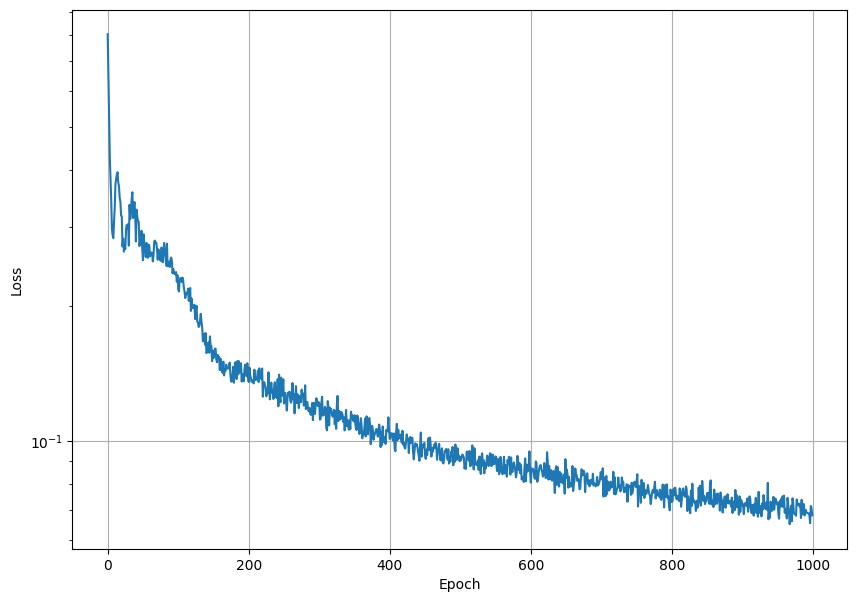

In [21]:
plt.figure(figsize=(10,7))
plt.semilogy(loss_hist)
plt.grid()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [32]:
u_pred_adam = U_model.predict(X_star)
f_pred = F_model(X_star[:,0], X_star[:,1])
        
error_adam = np.linalg.norm(u_star-u_pred_adam,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_adam))

Error u: 5.002120e-01


## plot results
Taken from original paper

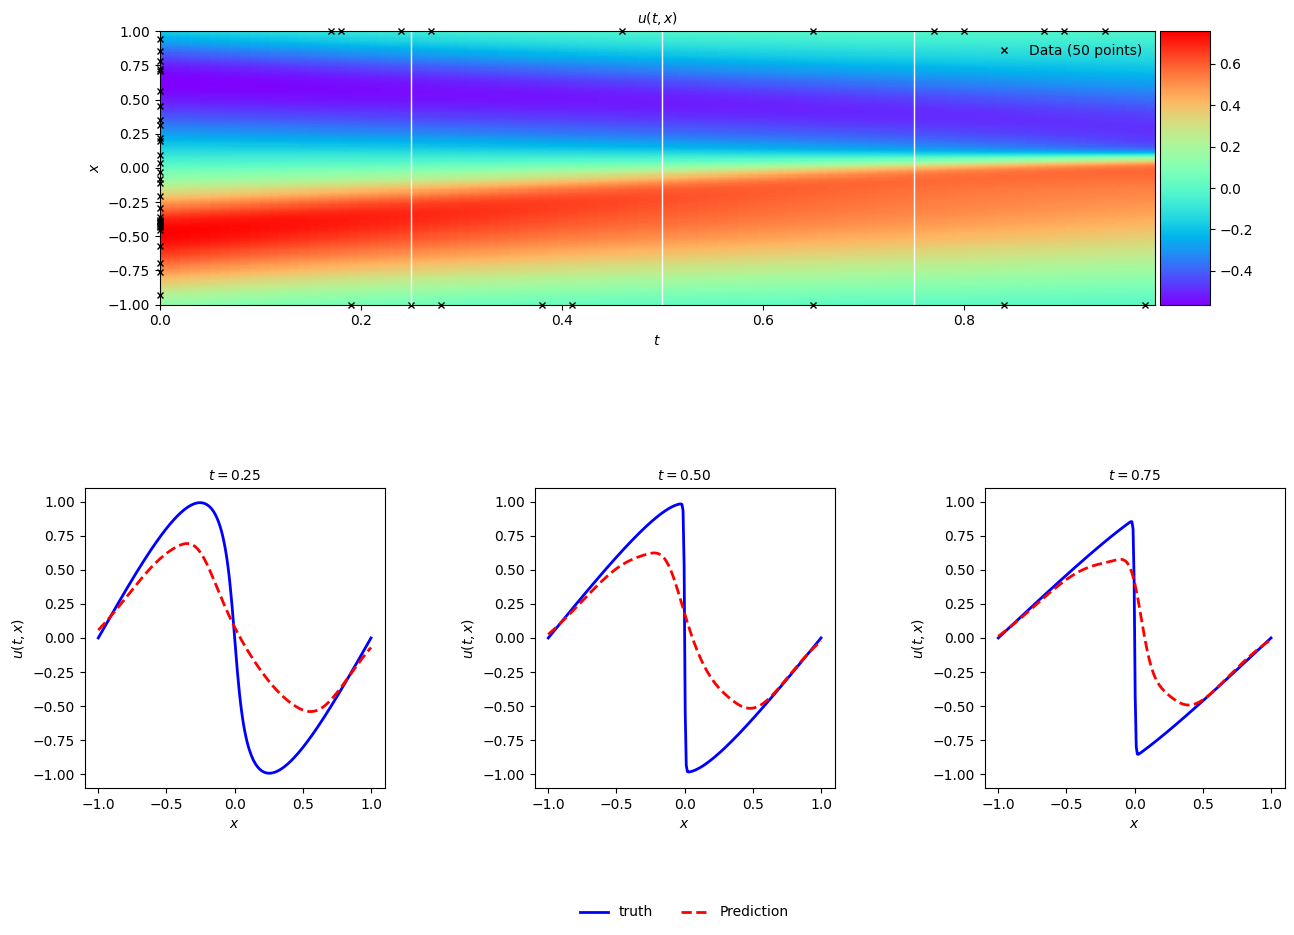

In [23]:
U_pred_adam = griddata(X_star, u_pred_adam.flatten(), (X, T), method='cubic')

plot_results(U_pred_adam, X_u_train, truth, x, t)

# PINN L-BFGS 

### Model

In [24]:
initializer = tf.keras.initializers.GlorotNormal()

inputs = layers.Input(shape=(2,), dtype=tf.float64)
z = layers.Lambda(lambda X: 2.0*(X - lb)/(ub - lb) - 1.0)(inputs)
for i in range(9):
    z = layers.Dense(20, activation="tanh", kernel_initializer=initializer, dtype=tf.float64)(z)
outputs = layers.Dense(1, kernel_initializer=initializer,dtype=tf.float64)(z)

U_model_lbfgs = tf.keras.Model(inputs=inputs, outputs=outputs)

U_model_lbfgs.summary()

def F_model_lbfgs(x,t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        tape.watch(x)
        u = tf.squeeze(tf.cast(U_model_lbfgs(tf.stack([x,t], 1)), tf.float64))
        u_t = tape.gradient(u,t)
        u_x = tape.gradient(u,x)
        u_xx = tape.gradient(u_x, x)
    f = u_t + u*u_x - (0.01/tf.constant(np.pi, dtype=tf.float64))*u_xx
    return f

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 2)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 20)                60        
_________________________________________________________________
dense_15 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_16 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_17 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_18 (Dense)             (None, 20)                420 

### lbfgs training

In [25]:
def make_val_grad_func(model, F_model, loss, train_x, train_y, train_f, print_freq=10):
    """Create the function required by tfp.optimizer.lbfgs_minimize.
    modified from https://gist.github.com/piyueh/712ec7d4540489aad2dcfb80f9a54993
    Args:
        model [in]: an instance of `tf.keras.Model` or its subclasses.
        loss [in]: a function with signature loss_value = loss(pred_y, true_y).
        train_x [in]: the input part of training data.
        train_y [in]: the output part of training data.

    Returns:
        A function that has a signature of:
            loss_value, gradients = f(model_parameters).
    """

    # obtain the shapes of all trainable parameters in the model
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)

    # vars for tf.dynamic_stitch and tf.dynamic_partition later
    count = 0
    idx = [] # stitch indices
    part = [] # partition indices

    for i, shape in enumerate(shapes):
        n = np.product(shape)
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
        part.extend([i]*n)
        count += n

    part = tf.constant(part)

    @tf.function
    def assign_new_model_parameters(params_1d):
        """A function updating the model's parameters with a 1D tf.Tensor.

        Args:
            params_1d [in]: a 1D tf.Tensor representing the model's trainable parameters.
        """

        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    # the function used by lbfgs
#     @tf.function
    def f(params_1d):
        """A function that can be used by tfp.optimizer.lbfgs_minimize.

        This function is created by function_factory.

        Args:
           params_1d [in]: a 1D tf.Tensor.

        Returns:
            A scalar loss and the gradients w.r.t. the `params_1d`.
        """

        with tf.GradientTape() as tape:
            # update the parameters in the model
            assign_new_model_parameters(params_1d)
            # calculate the loss
            u_pred = tf.cast(model(train_x), tf.float64)
            f_pred = F_model(train_f[:,0], train_f[:,1])
            loss_value = tf.reduce_mean(tf.square(train_y -u_pred)) + tf.reduce_mean(tf.square(f_pred))
            # loss_value = loss(model(train_x, training=True), train_y)

        # calculate gradients and convert to 1D tf.Tensor
        grads = tape.gradient(loss_value, model.trainable_variables)
        grads = tf.dynamic_stitch(idx, grads)

        # print out iteration & loss
        f.iter.assign_add(1)
        if f.iter % print_freq == 0:
            tf.print("Iter:", f.iter, "loss:", loss_value)

        # store loss value so we can retrieve later
        tf.py_function(f.history.append, inp=[loss_value], Tout=[])

        loss_value = loss_value.numpy().astype(np.float64)
        grads = grads.numpy().astype(np.float64)
        
        return loss_value, grads
        
    # store these information as members so we can use them outside the scope
    f.iter = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    f.history = []
    return f

In [26]:
from scipy import optimize

tf.keras.backend.set_floatx("float64")

X_u_train = tf.constant(X_u_train)
u_train= tf.constant(u_train)
X_f_train = tf.constant(X_f_train)

loss_fun = tf.keras.losses.MeanSquaredError()
func = make_val_grad_func(U_model_lbfgs, F_model_lbfgs, loss_fun, X_u_train, u_train, X_f_train)

# convert initial model parameters to a 1D tf.Tensor
init_params = tf.dynamic_stitch(func.idx, U_model_lbfgs.trainable_variables)

# train the model with L-BFGS solver
# results = tfp.optimizer.lbfgs_minimize(
#     value_and_gradients_function=func, 
#     initial_position=init_params, 
#     max_iterations=800
# )

results = optimize.minimize(
    func,
    method="L-BFGS-B",
    x0=np.array(init_params),
    jac=True,
    options={'maxiter':800,
            'maxcor': 50,
#             'finite_diff_rel_step':0.8
            },
    )



Iter: 10 loss: 0.23846785354632097
Iter: 20 loss: 0.15287143214719626
Iter: 30 loss: 0.11233031425845107
Iter: 40 loss: 0.10387832853579855
Iter: 50 loss: 0.093472323051560835
Iter: 60 loss: 0.086779513385267737
Iter: 70 loss: 0.079041496951634427
Iter: 80 loss: 0.073485208454312334
Iter: 90 loss: 0.0680132820795651
Iter: 100 loss: 0.060081069840107124
Iter: 110 loss: 0.050707094797420624
Iter: 120 loss: 0.046184974944574783
Iter: 130 loss: 0.041282691633110574
Iter: 140 loss: 0.034668662665935629
Iter: 150 loss: 0.031088488151273012
Iter: 160 loss: 0.03065540555131694
Iter: 170 loss: 0.025638503233504736
Iter: 180 loss: 0.0230745148054982
Iter: 190 loss: 0.020997072016217158
Iter: 200 loss: 0.018470624157723298
Iter: 210 loss: 0.016763498569245881
Iter: 220 loss: 0.015214248359384029
Iter: 230 loss: 0.013100321567481992
Iter: 240 loss: 0.010990304544672112
Iter: 250 loss: 0.010454912733559502
Iter: 260 loss: 0.00939741356016902
Iter: 270 loss: 0.008820230081672327
Iter: 280 loss: 0.00

In [27]:
results

      fun: 0.00043931840291972423
 hess_inv: <3441x3441 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.66455909e-04,  2.49963293e-05,  1.05847048e-04, ...,
       -6.41354962e-04,  2.29533713e-03,  1.71653861e-03])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 903
      nit: 800
     njev: 903
   status: 1
  success: False
        x: array([ 0.85895078, -0.07171834,  0.10257308, ..., -0.075016  ,
       -0.0577126 , -0.12777825])

In [28]:
# put final parameters back into model
func.assign_new_model_parameters(results.x)

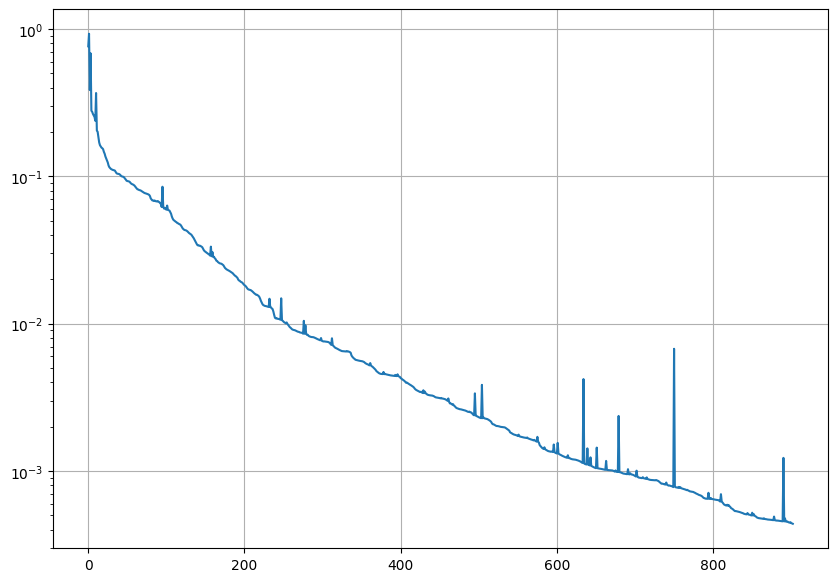

In [29]:
plt.figure(figsize=(10,7))
plt.semilogy(func.history)
plt.grid()
plt.show()

In [30]:
X_star = tf.constant(X_star)
u_pred = U_model_lbfgs(X_star)
f_pred = F_model_lbfgs(X_star[:,0], X_star[:,1])
        
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))

Error u: 1.261310e-02


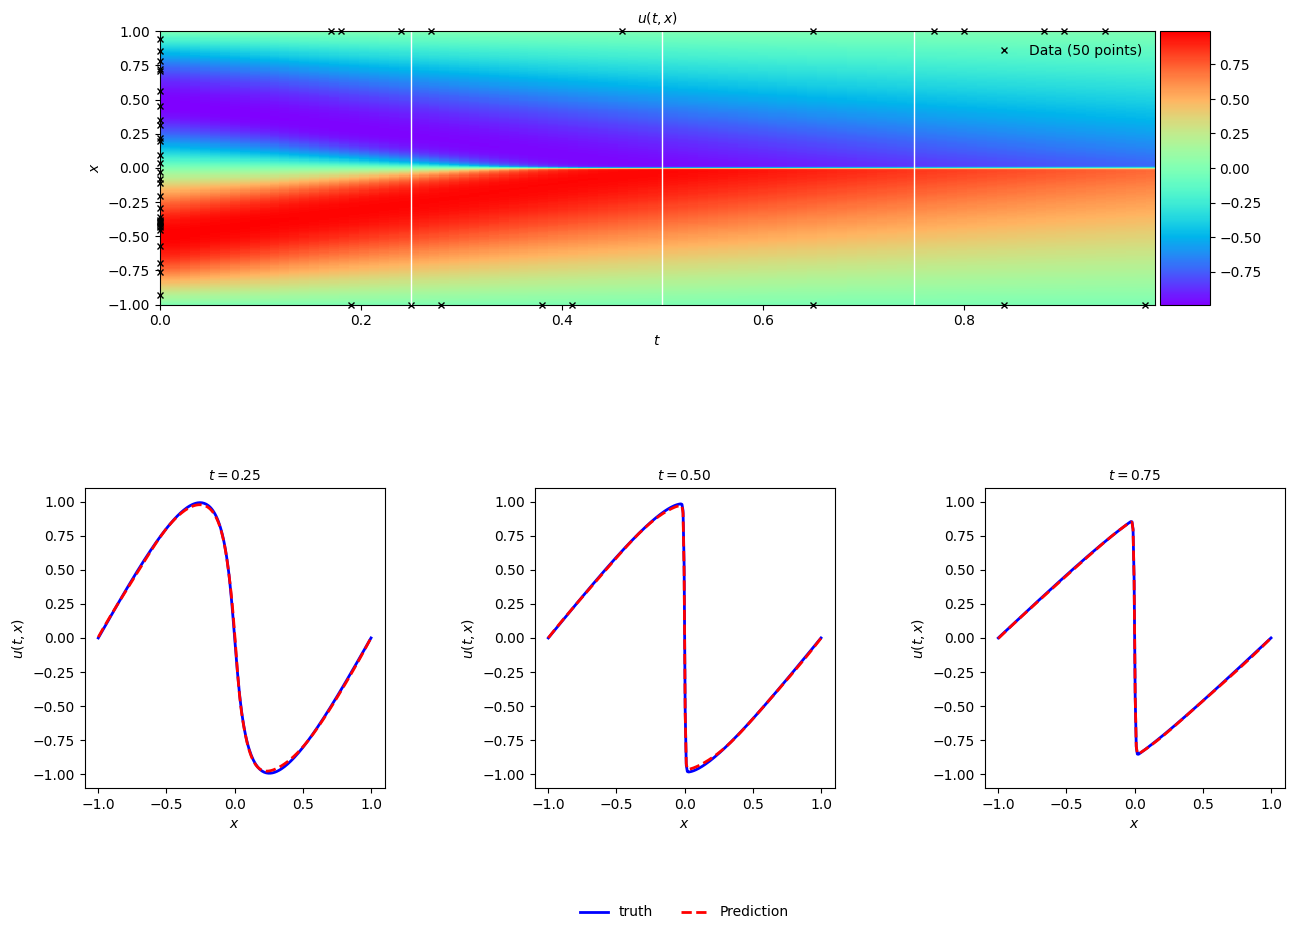

In [31]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.interpolate import griddata

plot_results(np.reshape(u_pred.numpy(), X.shape), X_u_train, truth, x, t)